## Some comparisons of filtering and smoothing (can be with or without the viewer)

### Hint for your task 2)
#### You must implement your filtering / smoothing in the HMMFilter / HMMSmoother classes in the file Filters. For the filter, this means also that you can use the visualisation through the Localizer, but you can call filter / smooth also directly from here, without the Localiser. Note also, that you must make use of the given models and the robot simulator in RobotSim!


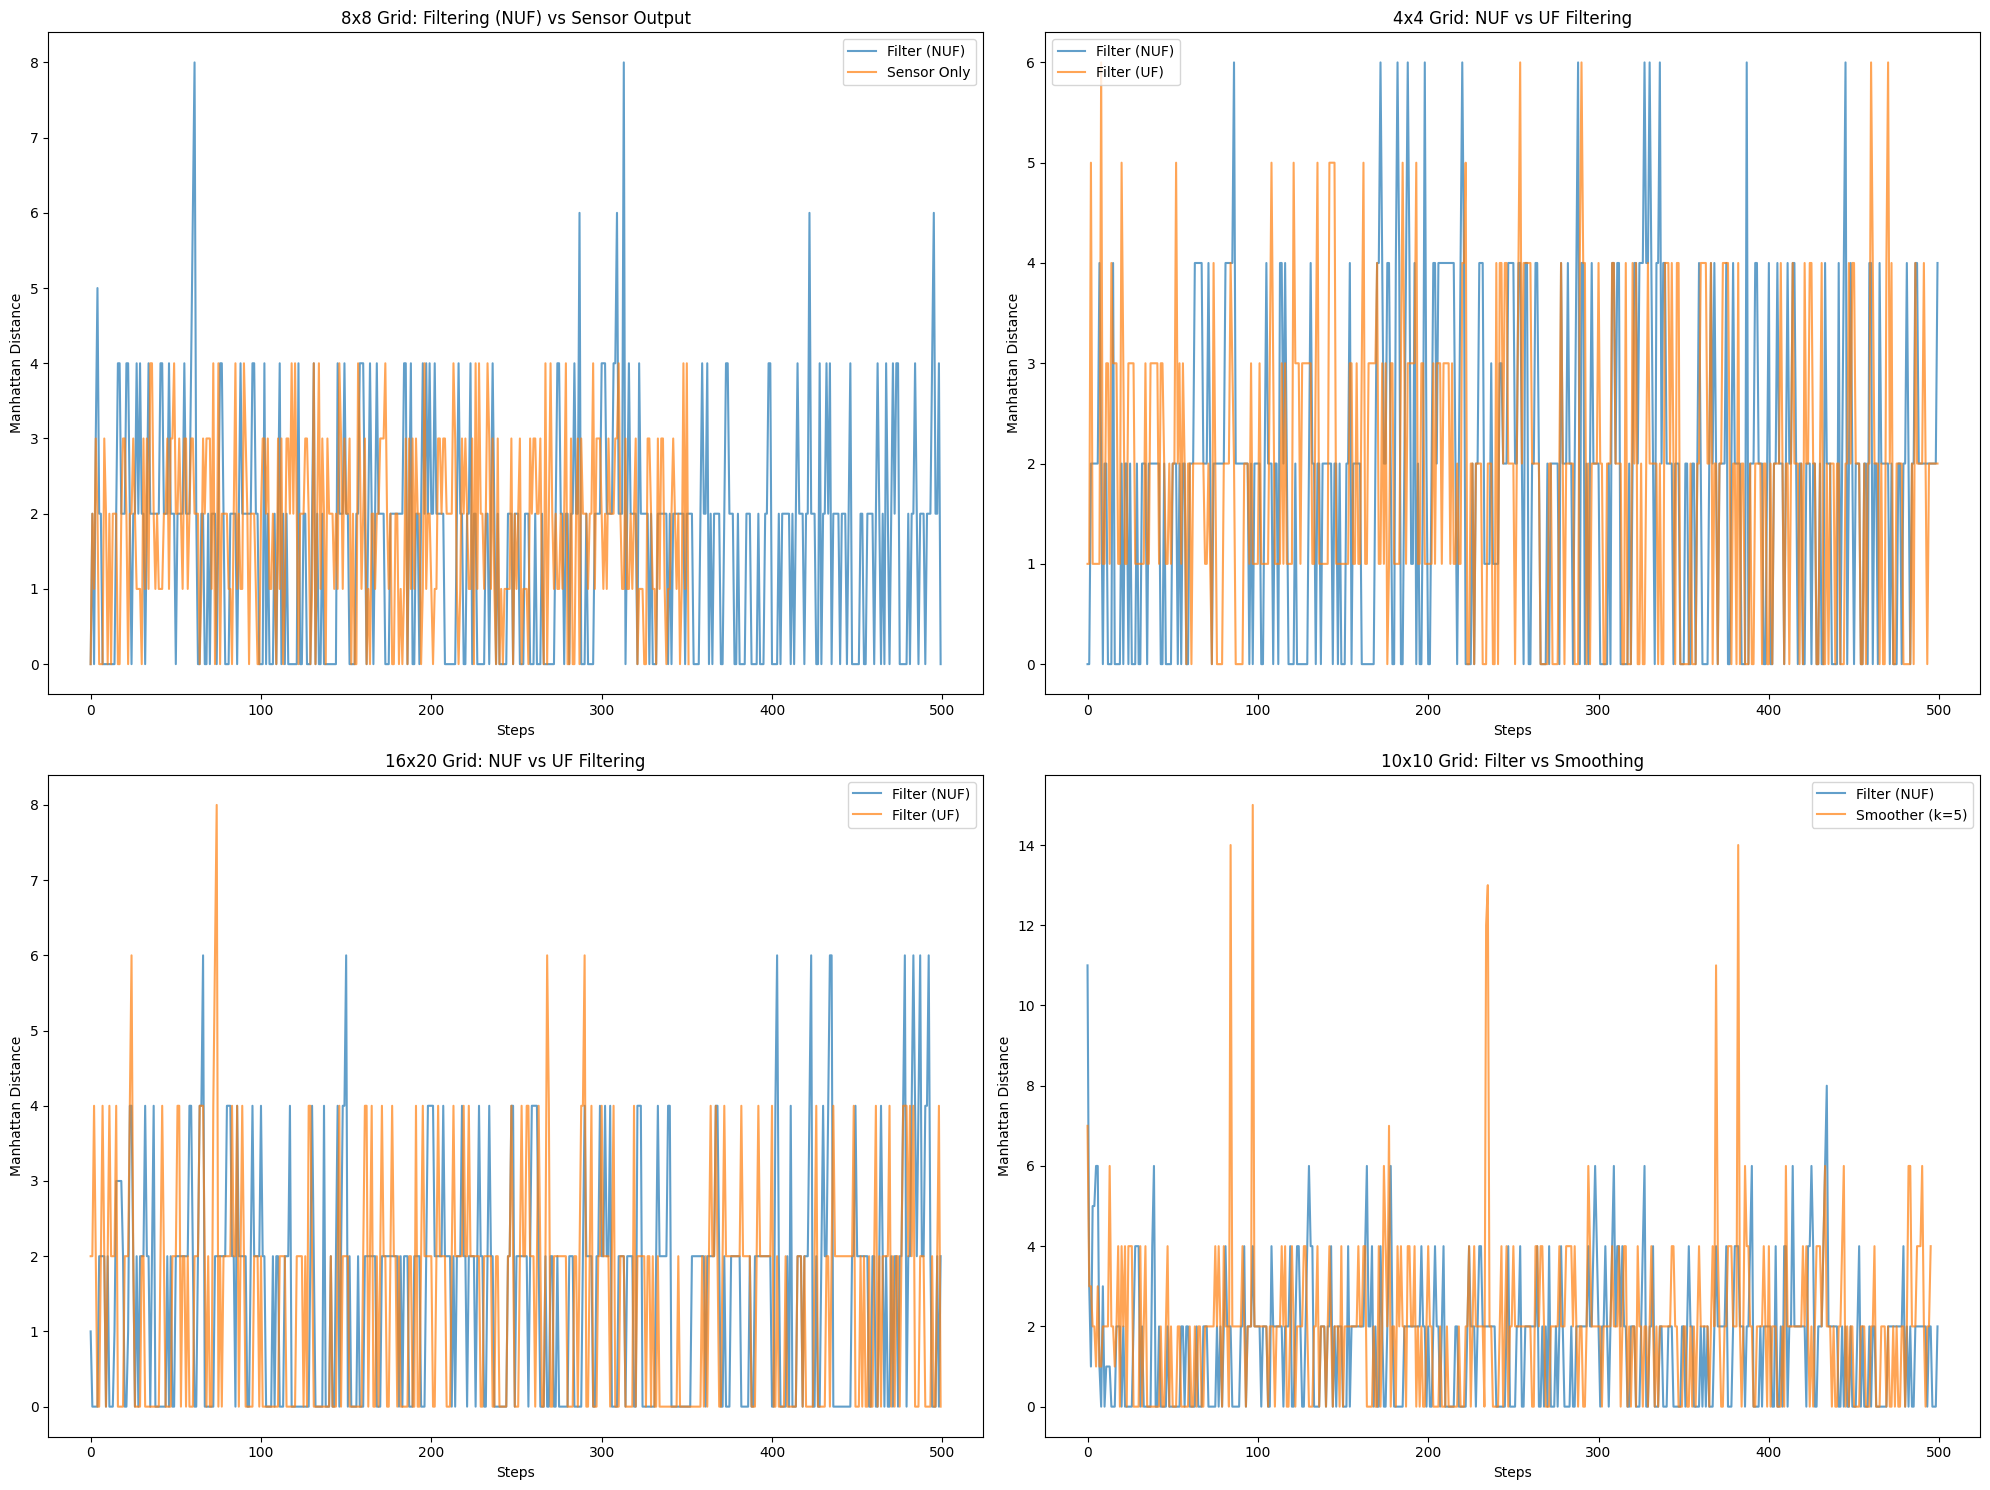

In [ ]:
from models import *
from models.ObservationModel_NUF import ObservationModel as ObsModelNUF
from models.ObservationModel_UF import ObservationModelUF as ObsModelUF
from Filters import HMMFilter, HMMSmoother
import numpy as np
import matplotlib.pyplot as plt
import random

# General function that we can run the simulations on with the different settings.
def run_simulation(rows, cols, obs_model_type, use_smoothing=False, compare_sensor_only=False):
    sm = StateModel(rows, cols)
    tm = TransitionModel(sm)
    om = obs_model_type(sm)
    
    prior = np.ones(sm.get_num_of_states()) / sm.get_num_of_states()
    hmm_filter = HMMFilter(prior, tm, om, sm)
    hmm_smoother = HMMSmoother(tm, om, sm) if use_smoothing else None
    
    true_state = random.randint(0, sm.get_num_of_states() - 1)
    rs = RobotSim(true_state, sm)
    
    num_steps = 500
    smoothing_window = 5 if use_smoothing else 0
    
    filter_distances = []
    smoother_distances = []
    sensor_distances = []
    sensor_readings = []
    
    for _ in range(num_steps):
        true_state = rs.move_once(tm)
        observation = rs.sense_in_current_state(om)
        sensor_readings.append(observation)
        
        # Update filter
        filter_belief = hmm_filter.filter(observation)
        filter_estimate = sm.state_to_position(np.argmax(filter_belief))
        true_pos = sm.state_to_position(true_state)
        filter_dist = abs(true_pos[0] - filter_estimate[0]) + abs(true_pos[1] - filter_estimate[1])
        filter_distances.append(filter_dist)
        
        # Sensor-only comparison
        if compare_sensor_only and observation is not None:
            sensor_pos = sm.reading_to_position(observation)
            sensor_dist = abs(true_pos[0] - sensor_pos[0]) + abs(true_pos[1] - sensor_pos[1])
            sensor_distances.append(sensor_dist)
        
        # Smoothing
        if use_smoothing and len(sensor_readings) >= smoothing_window:
            smoother_belief = hmm_smoother.smooth(sensor_readings[-smoothing_window:], filter_belief)
            smoother_estimate = sm.state_to_position(np.argmax(smoother_belief))
            smoother_dist = abs(true_pos[0] - smoother_estimate[0]) + abs(true_pos[1] - smoother_estimate[1])
            smoother_distances.append(smoother_dist)
    
    return filter_distances, smoother_distances, sensor_distances

# Plot configurations
plt.figure(figsize=(20, 15))

# Plot 1: 8x8 Grid (NUF vs Sensor Only)
filter_dists_nuf_8, _, sensor_dists_8 = run_simulation(8, 8, ObsModelNUF, compare_sensor_only=True)
plt.subplot(2, 2, 1)
plt.plot(filter_dists_nuf_8, label='Filter (NUF)', alpha=0.7)
plt.plot(sensor_dists_8, label='Sensor Only', alpha=0.7)
plt.title('8x8 Grid: Filtering (NUF) vs Sensor Output')
plt.xlabel('Steps')
plt.ylabel('Manhattan Distance')
plt.legend()

# Plot 2: 4x4 Grid (NUF vs UF)
filter_dists_nuf_4, _, _ = run_simulation(4, 4, ObsModelNUF)
filter_dists_uf_4, _, _ = run_simulation(4, 4, ObsModelUF)
plt.subplot(2, 2, 2)
plt.plot(filter_dists_nuf_4, label='Filter (NUF)', alpha=0.7)
plt.plot(filter_dists_uf_4, label='Filter (UF)', alpha=0.7)
plt.title('4x4 Grid: NUF vs UF Filtering')
plt.xlabel('Steps')
plt.ylabel('Manhattan Distance')
plt.legend()

# Plot 3: 16x20 Grid (NUF vs UF)
filter_dists_nuf_16, _, _ = run_simulation(16, 20, ObsModelNUF)
filter_dists_uf_16, _, _ = run_simulation(16, 20, ObsModelUF)
plt.subplot(2, 2, 3)
plt.plot(filter_dists_nuf_16, label='Filter (NUF)', alpha=0.7)
plt.plot(filter_dists_uf_16, label='Filter (UF)', alpha=0.7)
plt.title('16x20 Grid: NUF vs UF Filtering')
plt.xlabel('Steps')
plt.ylabel('Manhattan Distance')
plt.legend()

# Plot 4: 10x10 Grid (Filter vs Smoother)
filter_dists_nuf_10, smoother_dists_10, _ = run_simulation(10, 10, ObsModelNUF, use_smoothing=True)
plt.subplot(2, 2, 4)
plt.plot(filter_dists_nuf_10, label='Filter (NUF)', alpha=0.7)
plt.plot(smoother_dists_10, label='Smoother (k=5)', alpha=0.7)
plt.title('10x10 Grid: Filter vs Smoothing')
plt.xlabel('Steps')
plt.ylabel('Manhattan Distance')
plt.legend()

plt.tight_layout()
plt.show()